# EDA and Data Cleaning of the Scania Data

In this notebook, we will explore the contents of the scania dataset, and clean it, then preprocess its data before starting to work on it and build the models.

## Folder Upload and Unzip

In [11]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
!unzip "/content/drive/MyDrive/Zaka ML Specialisation/Capstone Project/Scania Dataset.zip" -d "/content/scania/"

Archive:  /content/drive/MyDrive/Zaka ML Specialisation/Capstone Project/Scania Dataset.zip
replace /content/scania/2024-34-2/data/test_labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: /content/scania/2024-34-2/data/test_labels.csv  
 extracting: /content/scania/2024-34-2/data/test_operational_readouts.csv  
 extracting: /content/scania/2024-34-2/data/test_specifications.csv  
 extracting: /content/scania/2024-34-2/data/train_operational_readouts.csv  
 extracting: /content/scania/2024-34-2/data/train_specifications.csv  
 extracting: /content/scania/2024-34-2/data/train_tte.csv  
 extracting: /content/scania/2024-34-2/data/validation_labels.csv  
 extracting: /content/scania/2024-34-2/data/validation_operational_readouts.csv  
 extracting: /content/scania/2024-34-2/data/validation_specifications.csv  
 extracting: /content/scania/2024-34-2/documentation/2024_IDA_challenge_v2.pdf  
 extracting: /content/scania/2024-34-2/documentation/Scania_component_X_PdM.pdf  


## Environment setup and imports

Step1: Import Libraries
Step2: Configure pandas display

In [13]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns  # for profiling visuals in EDA (pairplots, heatmaps)
sns.set(style="whitegrid")

from IPython.display import display


In [14]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
pd.set_option("display.max_rows", 200)

print("Setup complete.")

Setup complete.


## Define dataset paths and discover available CSVs

In [15]:
BASE_DIR = "/content/scania/2024-34-2"
DATA_DIR = os.path.join(BASE_DIR, "data")

# Find all csv files in the data folder
csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))

print(f"Found {len(csv_files)} CSV files:")
for f in csv_files:
    print(" -", os.path.basename(f))

Found 9 CSV files:
 - test_specifications.csv
 - validation_specifications.csv
 - test_labels.csv
 - test_operational_readouts.csv
 - validation_operational_readouts.csv
 - validation_labels.csv
 - train_specifications.csv
 - train_operational_readouts.csv
 - train_tte.csv


### Load all CSVs into individual DataFrames

In [16]:
dataframes = {}
for f in csv_files:
    key = os.path.splitext(os.path.basename(f))[0]
    df_tmp = pd.read_csv(f)

    # basic cleaning: strip whitespace from column headers
    df_tmp.columns = [c.strip() for c in df_tmp.columns]

    dataframes[key] = df_tmp
    print(f"[OK] Loaded {key}: shape = {df_tmp.shape}")

list(dataframes.keys())

[OK] Loaded test_specifications: shape = (5045, 9)
[OK] Loaded validation_specifications: shape = (5046, 9)
[OK] Loaded test_labels: shape = (5045, 2)
[OK] Loaded test_operational_readouts: shape = (198140, 107)
[OK] Loaded validation_operational_readouts: shape = (196227, 107)
[OK] Loaded validation_labels: shape = (5046, 2)
[OK] Loaded train_specifications: shape = (23550, 9)
[OK] Loaded train_operational_readouts: shape = (1122452, 107)
[OK] Loaded train_tte: shape = (23550, 3)


['test_specifications',
 'validation_specifications',
 'test_labels',
 'test_operational_readouts',
 'validation_operational_readouts',
 'validation_labels',
 'train_specifications',
 'train_operational_readouts',
 'train_tte']

### Inspect testlabels.csv specifically

In [17]:
label_key_candidates = [k for k in dataframes.keys() if "label" in k.lower()]
print("Possible label files:", label_key_candidates)

if len(label_key_candidates) == 0:
    print("WARNING: No 'label' file detected by name. Please confirm label source.")
else:
    label_key = label_key_candidates[0]
    df_labels = dataframes[label_key]
    print("Label dataframe preview:")
    display(df_labels.head())
    print("Info:")
    display(df_labels.info())

Possible label files: ['test_labels', 'validation_labels']
Label dataframe preview:


,vehicle_id,class_label
0,1,0
1,6,0
2,7,0
3,9,0
4,11,0


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5045 entries, 0 to 5044
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   vehicle_id   5045 non-null   int64
 1   class_label  5045 non-null   int64
dtypes: int64(2)
memory usage: 79.0 KB


None

## Data Preprocessing

### Attempt to identify feature tables vs label table

In [18]:
feature_tables = []
for name, df_tmp in dataframes.items():
    numeric_ratio = df_tmp.select_dtypes(include=[np.number]).shape[1] / max(df_tmp.shape[1], 1)
    contains_label_like = any(col.lower() in ["label","failure","target","y","class"] for col in df_tmp.columns)
    if (numeric_ratio > 0.5) and (not contains_label_like):
        feature_tables.append(name)

print("Potential feature tables:", feature_tables)

for ft in feature_tables:
    print(f"\nPreview of {ft}:")
    display(dataframes[ft].head())
    dataframes[ft].info()

Potential feature tables: ['test_labels', 'test_operational_readouts', 'validation_operational_readouts', 'validation_labels', 'train_operational_readouts', 'train_tte']

Preview of test_labels:


,vehicle_id,class_label
0,1,0
1,6,0
2,7,0
3,9,0
4,11,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5045 entries, 0 to 5044
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   vehicle_id   5045 non-null   int64
 1   class_label  5045 non-null   int64
dtypes: int64(2)
memory usage: 79.0 KB

Preview of test_operational_readouts:


,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,167_4,167_5,167_6,167_7,167_8,167_9,309_0,272_0,272_1,272_2,272_3,272_4,272_5,272_6,272_7,272_8,272_9,835_0,370_0,291_0,291_1,291_2,291_3,291_4,291_5,291_6,291_7,291_8,291_9,291_10,158_0,158_1,158_2,158_3,158_4,158_5,158_6,158_7,158_8,158_9,100_0,459_0,459_1,459_2,459_3,459_4,459_5,459_6,459_7,459_8,459_9,459_10,459_11,459_12,459_13,459_14,459_15,459_16,459_17,459_18,459_19,397_0,397_1,397_2,397_3,397_4,397_5,397_6,397_7,397_8,397_9,397_10,397_11,397_12,397_13,397_14,397_15,397_16,397_17,397_18,397_19,397_20,397_21,397_22,397_23,397_24,397_25,397_26,397_27,397_28,397_29,397_30,397_31,397_32,397_33,397_34,397_35
0,1,4.4,94410.0,7982.0,3115020.0,2625.0,1304.0,366624.0,232040.0,147104.0,422728.0,1651432.0,223425.0,55640.0,8816.0,3449.0,35.0,589556.0,165737.0,107063.0,255684.0,3008236.0,173097.0,6589.0,0.0,0.0,0.0,4466869.0,23994.0,328.0,184.0,237.0,329.0,104.0,48.0,84.0,76.0,60.0,144.0,28.0,132118.0,1565102.0,1976016.0,469225.0,314398.0,312200.0,194684.0,135352.0,150738.0,230483.0,232410.0,199.198833,54.364944,45.376778,51.823889,63.903611,77.826611,103.357333,122.073778,445.946667,548.500944,347.169167,372.139389,386.215167,499.586222,801.094944,3222.756944,2.499500,0.111111,0.019500,0.000000,263249.0,239652.0,280203.0,26432.0,21462.0,2674.0,409690.0,144340.0,519841.0,5432.0,1408.0,77.0,53152.0,67929.0,242384.0,5194.0,1653.0,63.0,8961.0,41455.0,127793.0,6974.0,952.0,14.0,5489.0,29540.0,72548.0,9696.0,1309.0,7.0,399.0,31843.0,89138.0,24101.0,5112.0,7.0
1,1,5.0,105405.0,9178.0,3467240.0,3225.0,1305.0,390896.0,252528.0,157824.0,449489.0,1856800.0,253593.0,67992.0,11048.0,3449.0,60.0,623008.0,185878.0,118129.0,267289.0,3361479.0,202841.0,6589.0,0.0,0.0,0.0,4943701.0,25893.0,342.0,196.0,251.0,345.0,113.0,48.0,100.0,92.0,62.0,162.0,30.0,158088.0,1716134.0,2127496.0,512135.0,355586.0,365554.0,229474.0,154686.0,173390.0,272595.0,249265.0,214.559444,57.916778,49.396222,56.415222,71.142889,86.661111,118.600889,144.118444,504.530722,608.977000,388.656500,417.743722,433.819444,581.277500,895.922444,3680.537111,3.353833,0.157056,0.021611,0.005111,293265.0,264698.0,322332.0,31124.0,26328.0,3465.0,437361.0,152455.0,547904.0,5839.0,1569.0,105.0,57192.0,74224.0,278030.0,5866.0,1934.0,70.0,9713.0,46425.0,150488.0,7906.0,1113.0,14.0,6177.0,33769.0,83147.0,12042.0,1841.0,7.0,455.0,35749.0,106366.0,28168.0,5420.0,7.0
2,1,8.2,214440.0,23348.0,7085790.0,8010.0,4897.0,461240.0,378264.0,313016.0,798401.0,3780424.0,799497.0,163376.0,20440.0,5017.0,80.0,766460.0,301796.0,232683.0,542839.0,6891368.0,554632.0,12672.0,0.0,0.0,0.0,9655430.0,71100.0,472.0,280.0,387.0,591.0,182.0,78.0,207.0,172.0,84.0,330.0,72.0,346542.0,2874998.0,3932292.0,1081529.0,821646.0,728798.0,488054.0,359072.0,429506.0,777365.0,387619.0,318.877389,94.245667,88.157389,105.322222,135.059667,168.275667,241.680333,311.298333,1192.676889,1494.561722,950.650556,1153.472333,1112.542167,1346.736667,2173.208889,7345.113111,7.363278,0.338889,0.034333,0.005111,593909.0,557452.0,742059.0,77997.0,69308.0,10136.0,626054.0,282383.0,830984.0,11293.0,3179.0,336.0,76239.0,164727.0,586345.0,13000.0,4056.0,168.0,16461.0,107409.0,319140.0,16734.0,2702.0,77.0,12722.0,75447.0,198090.0,26099.0,4516.0,21.0,1120.0,94017.0,293462.0,85596.0,16655.0,14.0
3,1,9.8,260190.0,29120.0,8696850.0,12525.0,6513.0,493728.0,455352.0,363984.0,964913.0,4553000.0,1108041.0,244696.0,30504.0,11025.0,220.0,811516.0,390093.0,268367.0,691548.0,8412239.0,790703.0,27885.0,0.0,0.0,0.0,11825379.0,87669.0,573.0,356.0,483.0,711.0,218.0,118.0,253.0,200.0,119.0,444.0,84.0,433888.0,3607464.0,4729144.0,1297032.0,1001154.0,864192.0,591780.0,442666.0,543564.0,988471.0,469672.0,370.512500,117.276333,108.131556,130.033722,167.011278,216.453611,305.310778,397.208056,1529.385333,1991.387167,1274.075667,1529.376278,1452.573167,1655.661556,2620.414278,8583.914889,8.950778,0.371833,0.060500,0.005111,814948.0,730765.0,938423.0,101867.0,89779.0,13272.0,669538.0,356870.0,918373.0,14647.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198140 entries, 0 to 198139
Columns: 107 entries, vehicle_id to 397_35
dtypes: float64(106), int64(1)
memory usage: 161.8 MB

Preview of validation_operational_readouts:


,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,167_4,167_5,167_6,167_7,167_8,167_9,309_0,272_0,272_1,272_2,272_3,272_4,272_5,272_6,272_7,272_8,272_9,835_0,370_0,291_0,291_1,291_2,291_3,291_4,291_5,291_6,291_7,291_8,291_9,291_10,158_0,158_1,158_2,158_3,158_4,158_5,158_6,158_7,158_8,158_9,100_0,459_0,459_1,459_2,459_3,459_4,459_5,459_6,459_7,459_8,459_9,459_10,459_11,459_12,459_13,459_14,459_15,459_16,459_17,459_18,459_19,397_0,397_1,397_2,397_3,397_4,397_5,397_6,397_7,397_8,397_9,397_10,397_11,397_12,397_13,397_14,397_15,397_16,397_17,397_18,397_19,397_20,397_21,397_22,397_23,397_24,397_25,397_26,397_27,397_28,397_29,397_30,397_31,397_32,397_33,397_34,397_35
0,10,3.0,46590.0,3696.0,2038959.0,1450.0,0.0,273826.0,339584.0,99834.0,250922.0,1411788.0,357113.0,27034.0,2198.0,0.0,70.0,44098.0,26120.0,12900.0,20960.0,279122.0,12725.0,124.0,0.0,0.0,0.0,2071653.0,0.0,712.0,320.0,353.0,569.0,208.0,48.0,177.0,192.0,120.0,248.0,80.0,21240.0,430191.0,546048.0,166546.0,149355.0,110700.0,83556.0,69345.0,106236.0,99001.0,165052.0,120.700139,40.085208,47.315069,63.458750,77.539236,88.971319,103.708056,123.059583,276.914306,342.500694,217.659722,305.552847,354.001042,604.575694,1479.010764,1283.698611,406.370972,0.191319,0.000000,0.005625,344190.0,249270.0,226995.0,12510.0,11610.0,2040.0,450781.0,134895.0,368565.0,7065.0,1261.0,30.0,27616.0,115141.0,242972.0,7380.0,1696.0,30.0,9181.0,93511.0,141781.0,7187.0,1110.0,15.0,6496.0,74880.0,100725.0,8026.0,855.0,15.0,495.0,91665.0,169125.0,51900.0,9362.0,0.0
1,10,7.4,127110.0,16716.0,6501456.0,4660.0,0.0,635642.0,609742.0,288036.0,781775.0,4592210.0,1715785.0,82866.0,2198.0,0.0,70.0,106579.0,46710.0,27098.0,56310.0,954252.0,57347.0,124.0,0.0,0.0,0.0,6530228.0,0.0,1648.0,664.0,689.0,1601.0,801.0,409.0,809.0,824.0,1041.0,1488.0,136.0,54936.0,1384740.0,1626471.0,450964.0,410724.0,344925.0,268488.0,232686.0,438867.0,405307.0,496081.0,344.130486,216.756250,324.007569,432.727222,518.133264,589.343333,641.517083,706.043542,1670.332778,1645.494792,1035.262361,1409.725069,1553.562014,2520.997153,4089.285139,1881.583194,443.728542,0.384444,0.010972,0.006667,1259850.0,1042830.0,718113.0,88172.0,85561.0,15570.0,1180141.0,429137.0,612150.0,37126.0,9346.0,616.0,97877.0,382653.0,501799.0,45165.0,12722.0,345.0,39304.0,320401.0,395162.0,48348.0,9840.0,345.0,25368.0,229531.0,295291.0,44312.0,7995.0,75.0,2265.0,414180.0,688891.0,258810.0,63167.0,1005.0
2,10,8.0,144015.0,19596.0,7327918.0,5230.0,0.0,654780.0,665756.0,300174.0,836039.0,5109160.0,2067521.0,100184.0,2198.0,0.0,70.0,109854.0,50894.0,29612.0,61306.0,1080604.0,63359.0,124.0,0.0,0.0,0.0,7301186.0,0.0,1736.0,688.0,745.0,1753.0,818.0,417.0,857.0,872.0,1169.0,1720.0,152.0,62064.0,1529361.0,1784754.0,491284.0,455994.0,387576.0,306828.0,267210.0,510417.0,485389.0,537817.0,367.498333,235.925972,352.601319,470.515278,571.397500,657.484097,723.373472,793.152431,1922.070833,1928.429792,1223.466389,1682.178958,1887.363958,2904.826597,4605.936458,2142.888542,473.712986,0.621667,0.058333,0.008472,1462831.0,1160565.0,801858.0,102558.0,96211.0,19351.0,1226987.0,468723.0,640155.0,41372.0,10576.0,751.0,105692.0,435138.0,539419.0,49711.0,14208.0,375.0,43144.0,370261.0,434463.0,54739.0,11010.0,375.0,28173.0,271081.0,335479.0,52203.0,9421.0,75.0,2415.0,487080.0,812071.0,300735.0,77477.0,1500.0
3,10,12.0,187560.0,24264.0,9286082.0,7420.0,2647.0,831628.0,794332.0,360066.0,955781.0,6172908.0,2799091.0,240002.0,10864.0,0.0,77.0,138006.0,64908.0,34672.0,69648.0,1346750.0,90503.0,528.0,0.0,0.0,0.0,9128870.0,0.0,2081.0,816.0,945.0,2113.0,1026.0,458.0,905.0,944.0,1337.0,1872.0,248.0,89406.0,1862604.0,2175282.0,577037.0,559746.0,486351.0,396810.0,344934.0,667206.0,693181.0,634061.0,433.936667,276.401389,399.583472,530.232500,634.750625,798.893889,866.071389,1030.670278,2402.546944,2533.728056,1607.636458,2230.352778,2531.052778,3608.536806,6521.322847,2875.241458,504.678889,0.625556,0.058333,0.008472,1890256.0,1409880.0,1033338.0,118353.0,121159.0,47431.0,1378562.0,5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196227 entries, 0 to 196226
Columns: 107 entries, vehicle_id to 397_35
dtypes: float64(106), int64(1)
memory usage: 160.2 MB

Preview of validation_labels:


,vehicle_id,class_label
0,10,0
1,16,0
2,18,0
3,23,0
4,45,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5046 entries, 0 to 5045
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   vehicle_id   5046 non-null   int64
 1   class_label  5046 non-null   int64
dtypes: int64(2)
memory usage: 79.0 KB

Preview of train_operational_readouts:


,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,167_4,167_5,167_6,167_7,167_8,167_9,309_0,272_0,272_1,272_2,272_3,272_4,272_5,272_6,272_7,272_8,272_9,835_0,370_0,291_0,291_1,291_2,291_3,291_4,291_5,291_6,291_7,291_8,291_9,291_10,158_0,158_1,158_2,158_3,158_4,158_5,158_6,158_7,158_8,158_9,100_0,459_0,459_1,459_2,459_3,459_4,459_5,459_6,459_7,459_8,459_9,459_10,459_11,459_12,459_13,459_14,459_15,459_16,459_17,459_18,459_19,397_0,397_1,397_2,397_3,397_4,397_5,397_6,397_7,397_8,397_9,397_10,397_11,397_12,397_13,397_14,397_15,397_16,397_17,397_18,397_19,397_20,397_21,397_22,397_23,397_24,397_25,397_26,397_27,397_28,397_29,397_30,397_31,397_32,397_33,397_34,397_35
0,0,11.2,167985.0,10787.0,7413813.0,2296.0,4110.0,1296420.0,1628265.0,630345.0,1269525.0,4772940.0,2706706.0,222225.0,6240.0,0.0,70.0,1435083.0,857662.0,384579.0,668642.0,7239843.0,398490.0,3887.0,0.0,0.0,0.0,8036751.0,0.0,1227.0,555.0,463.0,925.0,468.0,225.0,535.0,516.0,492.0,729.0,66.0,97056.0,2690052.0,2945268.0,788437.0,687480.0,595164.0,491232.0,532932.0,809628.0,505693.0,858410.0,203.676778,111.911500,147.265389,200.479944,230.306278,277.722417,315.748806,372.164528,864.246250,920.881111,637.901639,744.618944,880.866889,1272.323972,1847.623667,940.785694,2.900083,0.208444,0.056417,0.058444,446956.0,411420.0,203024.0,26636.0,29156.0,7616.0,449537.0,233352.0,139920.0,12648.0,2813.0,224.0,53161.0,178881.0,138250.0,13328.0,3581.0,88.0,16361.0,131601.0,116541.0,13506.0,2856.0,48.0,6337.0,105412.0,95728.0,15609.0,1984.0,8.0,784.0,150228.0,261904.0,93172.0,17874.0,452.0
1,0,11.4,167985.0,10787.0,7413813.0,2296.0,4111.0,1302855.0,1628265.0,630345.0,1269526.0,4772940.0,2706706.0,222225.0,6240.0,0.0,70.0,1440661.0,857662.0,384579.0,668642.0,7239843.0,398490.0,3887.0,0.0,0.0,0.0,8040811.0,0.0,1230.0,558.0,463.0,925.0,469.0,226.0,535.0,516.0,493.0,729.0,66.0,97056.0,2693100.0,2947368.0,788437.0,687480.0,595164.0,491232.0,532932.0,809628.0,505693.0,860571.0,204.256750,112.924250,147.265389,201.479944,230.306278,277.722417,315.748806,372.164528,864.246250,920.881111,637.901639,745.618944,880.866889,1272.323972,1847.623667,940.785694,2.900083,0.208444,0.056417,0.058444,446964.0,411420.0,203027.0,26638.0,29157.0,7616.0,451193.0,233354.0,139920.0,12649.0,2813.0,224.0,53210.0,178883.0,138252.0,13328.0,3582.0,88.0,16368.0,131601.0,116542.0,13507.0,2856.0,48.0,6339.0,105413.0,95729.0,15610.0,1984.0,8.0,784.0,150228.0,261905.0,93172.0,17874.0,452.0
2,0,19.6,331635.0,14525.0,13683604.0,2600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0,1787736.0,1133132.0,598351.0,1167062.0,12314224.0,460240.0,3887.0,0.0,0.0,0.0,12777022.0,0.0,2136.0,954.0,850.0,1420.0,722.0,412.0,880.0,666.0,586.0,1143.0,162.0,181632.0,4249020.0,4630440.0,1539133.0,1421172.0,1039764.0,749472.0,740724.0,995796.0,574045.0,1379191.0,321.671972,157.312500,193.792833,263.577611,310.711861,366.149250,415.642472,484.391167,1146.111611,1286.536333,900.062917,1123.232556,1449.545611,2140.037472,5046.748278,1151.010139,3.320194,0.218806,0.056778,0.058444,756665.0,647348.0,286811.0,30967.0,31213.0,7745.0,633790.0,423395.0,271940.0,16190.0,3573.0,232.0,75038.0,352791.0,327992.0,17325.0,4451.0,92.0,24028.0,234737.0,216619.0,17000.0,3476.0,48.0,12055.0,167693.0,142900.0,19263.0,2441.0,12.0,1420.0,204832.0,313485.0,106464.0,19306.0,452.0
3,0,20.2,354975.0,15015.0,14540449.0,2616.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0,1824409.0,1166074.0,634595.0,1233908.0,13275730.0,466753.0,3887.0,0.0,0.0,0.0,13612083.0,0.0,2218.0,1014.0,892.0,1471.0,749.0,425.0,901.0,702.0,589.0,1197.0,174.0,193728.0,4462548.0,4988028.0,1696022.0,1565484.0,1112544.0,789228.0,774588.0,1015104.0,576901.0,1428606.0,331.479028,162.731639,198.104472,269.712889,320.087333,377.478667,425.901361,495.749583,1173.882583,1323.460972,923.099361,1161.893139,1501.973944,2208.782833,5587.856667,1160.593833,3.336417,0.218806,0.056778,0.058444,812577.0,686860.0,302955.0,31927.0,31488.0,7749.0,651902.0,478279.0,292109.0,16755.0,3753.0,232.0,77118.0,39408

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122452 entries, 0 to 1122451
Columns: 107 entries, vehicle_id to 397_35
dtypes: float64(106), int64(1)
memory usage: 916.3 MB

Preview of train_tte:


,vehicle_id,length_of_study_time_step,in_study_repair
0,0,510.0,0
1,2,281.8,0
2,3,293.4,0
3,4,210.0,0
4,5,360.4,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23550 entries, 0 to 23549
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   vehicle_id                 23550 non-null  int64  
 1   length_of_study_time_step  23550 non-null  float64
 2   in_study_repair            23550 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 552.1 KB


### Business assumption: choose main feature table

In [19]:
# We will assume the first candidate in feature_tables is the main telemetry table.
# If this assumption is wrong, update MAIN_FEATURE_KEY manually.

if len(feature_tables) == 0:
    raise ValueError("No candidate feature tables were detected. Please inspect the dataset manually.")

MAIN_FEATURE_KEY = feature_tables[0]
df_features_raw = dataframes[MAIN_FEATURE_KEY].copy()

print("Selected feature table:", MAIN_FEATURE_KEY)
print("Shape:", df_features_raw.shape)
display(df_features_raw.head())

Selected feature table: test_labels
Shape: (5045, 2)


,vehicle_id,class_label
0,1,0
1,6,0
2,7,0
3,9,0
4,11,0


###Standardize column names and basic sanity checks

In [20]:
# Normalize column naming conventions
# - Lowercase
# - Replace spaces and special chars with underscores

def normalize_columns(df):
    df = df.copy()
    new_cols = []
    for c in df.columns:
        c_norm = c.strip().lower().replace(" ", "_").replace("-", "_").replace("/", "_")
        new_cols.append(c_norm)
    df.columns = new_cols
    return df

df_features = normalize_columns(df_features_raw)

print("Columns after normalization:")
print(df_features.columns.tolist()[:50])
display(df_features.head(3))

print("Data types summary:")
display(df_features.dtypes.value_counts())


Columns after normalization:
['vehicle_id', 'class_label']


,vehicle_id,class_label
0,1,0
1,6,0
2,7,0


Data types summary:


,count
int64,2


## Exploratory Data Analysis

### High-level EDA: shape, missingness, dtypes

In [21]:
print("Shape:", df_features.shape)
print("\nData types:")
display(df_features.dtypes)

print("\nMissing values (top 30 columns by missing %):")
missing_pct = df_features.isna().mean().sort_values(ascending=False) * 100
display(missing_pct.head(30))

print("\nBasic describe():")
display(df_features.describe(include=[np.number]).T.head(30))

Shape: (5045, 2)

Data types:


,0
vehicle_id,int64
class_label,int64



Missing values (top 30 columns by missing %):


,0
vehicle_id,0.0
class_label,0.0



Basic describe():


,count,mean,std,min,25%,50%,75%,max
vehicle_id,5045.0,16803.188702,9761.914799,1.0,8300.0,16755.0,25299.0,33638.0
class_label,5045.0,0.083053,0.523099,0.0,0.0,0.0,0.0,4.0


### Visualize missingness distribution

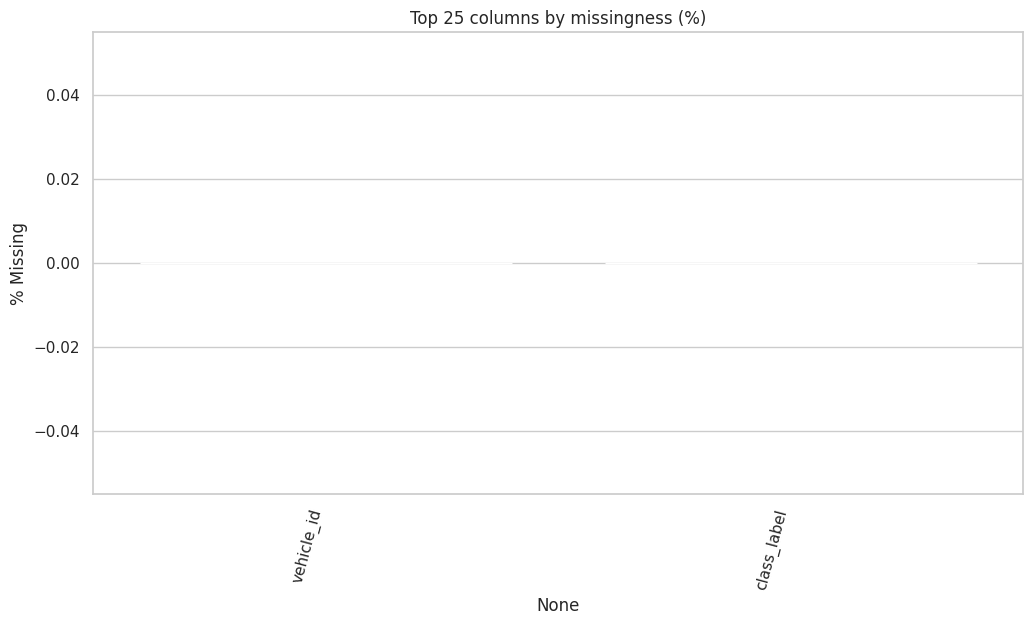

In [22]:
# This is useful to drive imputation strategy.

missing_pct = df_features.isna().mean().sort_values(ascending=False) * 100

plt.figure(figsize=(12,6))
sns.barplot(
    x=missing_pct.head(25).index,
    y=missing_pct.head(25).values
)
plt.xticks(rotation=75, ha="right")
plt.ylabel("% Missing")
plt.title("Top 25 columns by missingness (%)")
plt.show()


### Detect obvious constant / quasi-constant columns

In [23]:
# We'll flag columns with low variance.

low_variance_cols = []
for col in df_features.columns:
    if df_features[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
        unique_vals = df_features[col].nunique(dropna=True)
        if unique_vals <= 1:
            low_variance_cols.append(col)

print("Constant columns:", low_variance_cols)

Constant columns: []


### Check duplicates (row-level)

In [24]:
#Check duplicate rows, which can bias downstream training splits

dup_count = df_features.duplicated().sum()
dup_pct = 100.0 * dup_count / len(df_features) if len(df_features) > 0 else 0
print(f"Duplicate rows: {dup_count} ({dup_pct:.2f}%)")

# Preview duplicates if any
if dup_count > 0:
    display(df_features[df_features.duplicated(keep=False)].head())


Duplicate rows: 0 (0.00%)


### Correlation analysis among numeric features

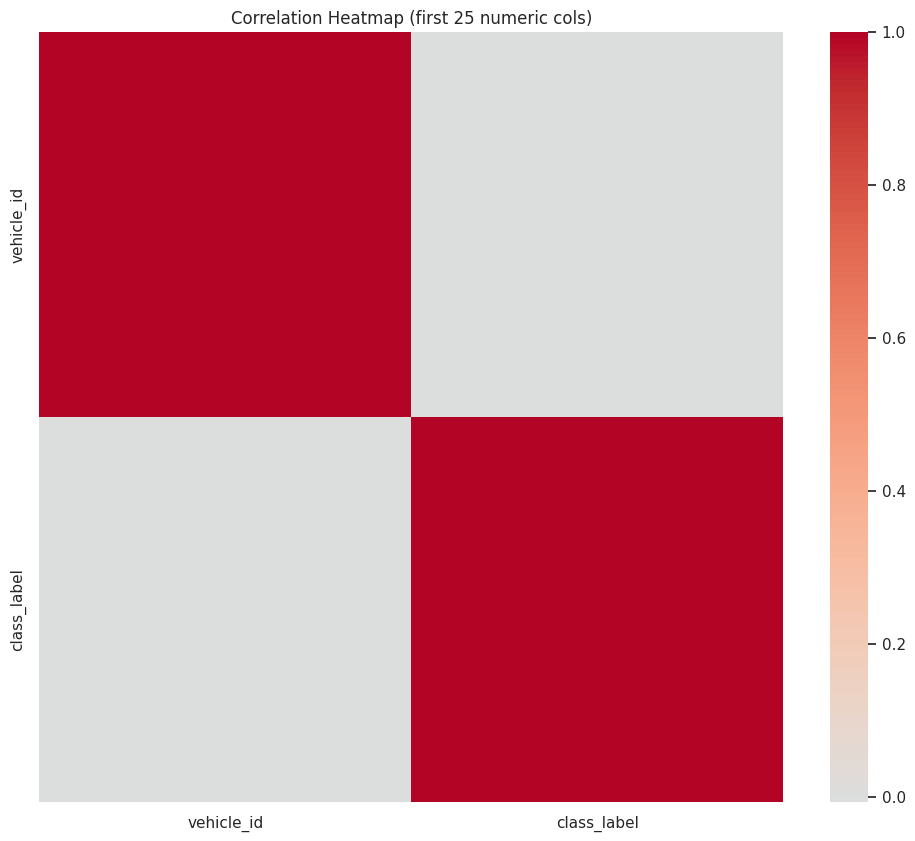

In [25]:
#Correlation heatmap to assess multicollinearity
# NOTE: For very wide tables (hundreds of columns), plotting full heatmap is heavy.
# We will sample up to N columns.

N = 25  # adjust upward if dataset is narrower
numeric_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
subset_cols = numeric_cols[:N]

corr_matrix = df_features[subset_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (first 25 numeric cols)")
plt.show()


### Outlier screening (univariate) using IQR rule

In [26]:
# Outlier check per numerical column using IQR
# We'll compute % of rows considered outliers for each column.
# This guides whether we clip/winsorize later.

outlier_stats = []

for col in numeric_cols:
    q1 = df_features[col].quantile(0.25)
    q3 = df_features[col].quantile(0.75)
    iqr = q3 - q1
    if iqr == 0:
        outlier_pct = 0.0
    else:
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        mask_outliers = (df_features[col] < lower) | (df_features[col] > upper)
        outlier_pct = 100.0 * mask_outliers.mean()
    outlier_stats.append((col, outlier_pct))

outlier_stats = sorted(outlier_stats, key=lambda x: x[1], reverse=True)
print("Top 20 columns by outlier %:")
for col, pct in outlier_stats[:20]:
    print(f"{col}: {pct:.2f}%")


Top 20 columns by outlier %:
vehicle_id: 0.00%
class_label: 0.00%


### Merge features with labels (supervised learning prep)

In [27]:
# Attempt to join feature matrix with labels.
# We need a join key. In many industrial datasets it's something like 'id', 'unit_nr', 'timestamp', etc.
# We'll try to infer an intersection of columns between df_features and df_labels.

if 'df_labels' in globals():
    common_cols = set(df_features.columns).intersection(set(df_labels.columns))
    print("Common columns between features and labels:", common_cols)

    if len(common_cols) == 0:
        print("No common key detected automatically. You will need to merge manually later.")
        df_merged = None
    else:
        # naive merge on all common cols (could create duplication if key not unique)
        merge_on = list(common_cols)
        df_merged = pd.merge(df_features, df_labels, on=merge_on, how="left")

        print("Merged shape:", df_merged.shape)
        display(df_merged.head())
else:
    print("No labels dataframe found, skipping supervised merge step.")
    df_merged = None


Common columns between features and labels: {'vehicle_id', 'class_label'}
Merged shape: (5045, 2)


,vehicle_id,class_label
0,1,0
1,6,0
2,7,0
3,9,0
4,11,0


### Data cleaning pipeline: drop constant columns, handle missing values

In [28]:
# Create a cleaned numeric dataset for modeling
# Strategy:
# 1. Drop constant columns.
# 2. Impute missing numeric values with median.
# 3. Optionally drop rows with too many missing values.

df_clean = df_features.copy()

# 1. Drop constant columns
if len(low_variance_cols) > 0:
    df_clean = df_clean.drop(columns=low_variance_cols)
    print(f"Dropped {len(low_variance_cols)} constant columns.")

# 2. Impute numeric columns with median
for col in df_clean.columns:
    if df_clean[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
        median_val = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_val)
    else:
        # for non-numeric (categorical/text), simple fillna with placeholder
        df_clean[col] = df_clean[col].fillna("UNKNOWN")

# 3. (Optional) Drop rows with too many still-missing values
row_missing_pct = df_clean.isna().mean(axis=1) * 100
threshold_pct = 50.0  # configurable governance parameter
mask_keep = row_missing_pct <= threshold_pct
print(f"Rows kept after missingness filter ({threshold_pct}% max missing): {mask_keep.mean()*100:.2f}%")

df_clean = df_clean[mask_keep].reset_index(drop=True)

print("Cleaned dataset shape:", df_clean.shape)
display(df_clean.head())


Rows kept after missingness filter (50.0% max missing): 100.00%
Cleaned dataset shape: (5045, 2)


,vehicle_id,class_label
0,1,0
1,6,0
2,7,0
3,9,0
4,11,0


### Feature scaling (StandardScaler)

In [29]:
#Scale numeric features for downstream ML models (SVM, logistic regression, etc.)
# We'll produce:
# - X_scaled: scaled numeric feature matrix
# - scaler object for future inference.

from sklearn.preprocessing import StandardScaler

numeric_cols_clean = df_clean.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()

X_scaled = scaler.fit_transform(df_clean[numeric_cols_clean])
X_scaled = pd.DataFrame(X_scaled, columns=numeric_cols_clean)

print("Scaled feature matrix shape:", X_scaled.shape)
display(X_scaled.head())


Scaled feature matrix shape: (5045, 2)


,vehicle_id,class_label
0,-1.721369,-0.158786
1,-1.720856,-0.158786
2,-1.720754,-0.158786
3,-1.720549,-0.158786
4,-1.720344,-0.158786


### Encode label column (if present)

In [30]:
#Prepare target variable y if we have labels.

from sklearn.preprocessing import LabelEncoder

if df_merged is not None:
    # try to detect label column heuristically
    label_candidates = [c for c in df_merged.columns if c.lower() in ["label","failure","target","y","class"]]

    if len(label_candidates) == 0:
        print("No obvious label column found in merged data. Please define y manually.")
        y = None
    else:
        LABEL_COL = label_candidates[0]
        print("Using label column:", LABEL_COL)

        y_raw = df_merged[LABEL_COL]
        le = LabelEncoder()
        y = le.fit_transform(y_raw.astype(str))

        print("Encoded label distribution:")
        unique, counts = np.unique(y, return_counts=True)
        for u, c in zip(unique, counts):
            print(f"Class {u}: {c} rows")

        # align X_scaled with df_merged rows if possible
        # NOTE: this assumes df_clean rows align with df_merged rows;
        # if merge changed row order or duplicated rows, you will need a proper key.
else:
    print("Skipping label encoding step because df_merged is None.")
    y = None


No obvious label column found in merged data. Please define y manually.


### Export cleaned dataset artifacts

In [31]:
# Persist cleaned artifacts for modeling phase (next notebook)
# We export:
# - df_clean.csv  : cleaned + imputed raw features
# - X_scaled.csv  : standardized numeric features
# - merged_with_labels.csv (if available)

OUTPUT_DIR = os.path.join(BASE_DIR, "preprocessed_outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

df_clean_path = os.path.join(OUTPUT_DIR, "df_clean.csv")
df_clean.to_csv(df_clean_path, index=False)

X_scaled_path = os.path.join(OUTPUT_DIR, "X_scaled.csv")
X_scaled.to_csv(X_scaled_path, index=False)

if df_merged is not None:
    merged_path = os.path.join(OUTPUT_DIR, "merged_with_labels.csv")
    df_merged.to_csv(merged_path, index=False)
    print("Saved:", merged_path)

print("Saved:", df_clean_path)
print("Saved:", X_scaled_path)

print("Data engineering / preprocessing pipeline complete.")


Saved: /content/scania/2024-34-2/preprocessed_outputs/merged_with_labels.csv
Saved: /content/scania/2024-34-2/preprocessed_outputs/df_clean.csv
Saved: /content/scania/2024-34-2/preprocessed_outputs/X_scaled.csv
Data engineering / preprocessing pipeline complete.
